# Getting starting with the GRIDmeter™ library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the stratified sampling model, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.


    

# Background -- why this library

The `gridmeter` library originated from a project lead by Recurve Analytics, Inc. and funded by the US Dept. of Energy designed to identify practical methods for analyzing energy efficiency which are robust to external shocks (e.g. COVID-19).  From June through September 2020, Recurve hosted a series of meetings with industry stakeholders to discuss methods for constructing comparison groups, with the goal of presenting a recommended standard method to the GRID working group, a subsidiary of the Linux Foundation for Energy.  During this time, Recurve developed Python software to implement stratified sampling and demonstrate its effectiveness in practice.  The `gridmeter` library is the open-source Apache-licensed output of this process and is available to be used by anyone. 

This notebook will take you through several things that this library can do.


## Note on tutorial scope and related libraries

This tutorial assumes the reader has properly installed python and has a basic working knowledge of python syntax and usage. 

The `gridmeter` library uses `pandas` data frames as its principle way of representing data, therefore all inputs and outputs are data frames; see [this tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for information on how to use `pandas`.  The `plotnine` library is used to make visualizations which can be embedded in a Jupyter notebook or saved as .pngs; see [this website](https://plotnine.readthedocs.io/en/stable/) for information on `plotnine`.

In [63]:
import subprocess
import sys

for package in ['gridmeter', 'pandas', 'plotnine']:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import gridmeter as gm

## Viewing documentation

You can view code documentation by appending a question mark to a function and then executing that code, as in the following example:

In [4]:
gm.Stratified_Sampling?

Init signature: gm.Stratified_Sampling(settings: 'Settings | None' = None)
Docstring:      <no docstring>
File:           /app/applied_data_science/gridmeter/gridmeter/gridmeter/_stratified_sampling/create_comparison_groups.py
Type:           type
Subclasses:     

# Problem definition

Typically one begins with two populations of meters: a **treatment group**, and a **comparison pool**.  The treatment group consists of those meters for which savings needs to be tracked, e.g. if they represent customers participating in an energy efficiency program.  The comparison pool consists of all of the available meters that are not part of the treatment group.  The goal is to select a **comparison group** which is a subset of the comparison pool, such that the control group is **similar** to the treatment group.  The comparison group will then provide a realistic counterfactual compared to the treatment group and can be used to accurately estimate the impact of a program.

# Setting up tutorial data

Ordinarily you would start with your own time-series meter data, but for our purposes we'll generate some very basic dummy data.  `gridmeter` provides some functions which generate populations of dummy meters with randomly varying base and peak usage levels.  We'll use the following code to generate a population of 1000 treatment meters and 10000 comparison pool meters, and specify some consumption values for the treatment group that differ from the default, so that the groups are differently distributed.  The treatment group is specified by filtering the comparison pool along one of the available features (currently `winter_usage`, `summer_uage`, and `annual_usage`).  For this example, we'll assume our treatment group targets customers with usage above the 50th percentile in both summer and winter.

Once the population has been generated, we can create feature data and longitudinal data.  These functions take a few minutes to run upon first execution, but the results are cached to disk so subsequent runs will be fast.

Note: the structure of the dataframes is extremely important going forward.

In [78]:
# Loadshape and feature data

n_treatment = 1000
n_pool = 10000

filter = lambda df: df[(df.summer_usage > df.summer_usage.quantile(0.5)) & (df.winter_usage > df.winter_usage.quantile(0.5))]
population = gm.DummyTreatmentPoolPopulation(n_treatment=n_treatment, n_pool=n_pool, 
                                              treatment_filter_function=filter)

df_features= population.features()
df_features_pool = df_features[df_features['set']=='pool']
df_features_treatment = df_features[df_features['set']=='treatment']
df_loadshape = population.features_monthly()

df_features_pool = df_features_pool.rename(columns={'meter_id':'id'}).drop(columns=['set'])
df_ls_pool = df_loadshape.loc[df_features_pool["id"]]
df_ls_pool = df_ls_pool.stack().reset_index().rename(columns={'meter_id':'id', 'month':'time', 0:'loadshape'})

df_features_treatment = df_features_treatment.rename(columns={'meter_id':'id'}).drop(columns=['set'])
df_ls_treatment = df_loadshape.loc[df_features_treatment["id"]]
df_ls_treatment = df_ls_treatment.stack().reset_index().rename(columns={'meter_id':'id', 'month':'time', 0:'loadshape'})

# Fake time series data
# Create a testing dataframe having an id, datetime of 1 month intervals, observed and modeled values 
num_intervals = 12  # 1 per month

# Create a DataFrame with 'id', 'datetime', 'observed', and 'modeled' columns
df_ts_treatment = pd.DataFrame({
    'id': np.repeat(df_features_treatment["id"].values, num_intervals),  # only 3 ids for easier comparison
    'datetime': pd.date_range(start='2023-01-01', periods=num_intervals, freq='M').tolist() * n_treatment, 
    'observed': np.random.rand(num_intervals * n_treatment),  # randomized
    'modeled': np.random.rand(num_intervals * n_treatment)  # randomized
})

INFO:root:Caching objects to .cache


In [79]:
# Loadshape dataframe format, columns: [id, time, loadshape]
# time depends on whatever you have aggregated to

print("Loadshape dataframe format:")
df_ls_treatment.head()

Loadshape dataframe format:


id  time    loadshape
0  meter_7     1  1306.549164
1  meter_7     2  1329.713267
2  meter_7     3  1495.943759
3  meter_7     4  1413.263240
4  meter_7     5  1110.672360

In [80]:
# Time Series dataframe format, columns: [id, datetime, Optional[observed], Optional[modeled], Optional[error]]
# observed, modeled, and error are optional, but at least one must be present
# if you are using observed and modeled to calculate error, then you must have both observed and modeled

print("Time series dataframe format:")
df_ts_treatment.head()

Time series dataframe format:


id   datetime  observed   modeled
0  meter_7 2023-01-31  0.988688  0.998785
1  meter_7 2023-02-28  0.099159  0.426685
2  meter_7 2023-03-31  0.295648  0.372254
3  meter_7 2023-04-30  0.385422  0.891731
4  meter_7 2023-05-31  0.449711  0.121373

In [81]:
# Features dataframe format, columns: [id, feature1, feature2, ...]
# features can be named whatever you like and you may include as many as you like

print("Features dataframe format:")
df_features_treatment.head()

Features dataframe format:


id  winter_usage  summer_usage  annual_usage
7    meter_7   4635.478940   4013.199787  17006.951477
24  meter_24   5282.793720   4188.890168  18575.109967
48  meter_48   4712.178049   4070.254860  19811.764066
56  meter_56   4629.797900   3975.296379  17700.280488
67  meter_67   4489.516078   4341.698755  16963.187448

# Setting up data

Gridmeter uses the `Data` class as the inputs to all of the comparison group methods. Its purpose is to validate your data and to perform the necessary transformations to go into the comparison group methods. `Data` is instantiated with `Data_Settings`. Once instantiated the method `.set_data` can be called using one of `loadshape_df` and `time_series_df` as well as `features_df` depending upon your needs. If you input `time_series_df` it will compute the loadshape.

Method requirements:
- Clustering: Loadshape
- Individual Meter Matching: Loadshape
- Stratified Sampling: Loadshape/Features (depends upon settings)

In [32]:
data_settings = gm.Data_Settings(time_period='month')

In [40]:
# Let's make an invalid entry to see what happens
df_ts_treatment.loc[0, 'observed'] = np.nan

ts_data = gm.Data().set_data(time_series_df=df_ts_treatment)

ts_data.excluded_ids

id                                             reason
0        meter_0  Minimum time interval is more than the specifi...
1    meter_10002  Minimum time interval is more than the specifi...
2    meter_10008  Minimum time interval is more than the specifi...
3    meter_10012  Minimum time interval is more than the specifi...
4    meter_10014  Minimum time interval is more than the specifi...
..           ...                                                ...
995   meter_9919  Minimum time interval is more than the specifi...
996   meter_9925  Minimum time interval is more than the specifi...
997    meter_997  Minimum time interval is more than the specifi...
998   meter_9979  Minimum time interval is more than the specifi...
999   meter_9985  Minimum time interval is more than the specifi...

[1000 rows x 2 columns]

In [48]:
# Set data classes
# for the purposes of this tutorial, we'll set both loadshapes and features

data_settings = gm.Data_Settings(time_period=None)

pool_data = gm.Data(data_settings)
pool_data.set_data(loadshape_df=df_ls_pool, features_df=df_features_pool)

treatment_data = gm.Data(data_settings)
treatment_data.set_data(loadshape_df=df_ls_treatment, features_df=df_features_treatment)

/app/applied_data_science/gridmeter/gridmeter/gridmeter/_utils/data_processing.py:142: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
/app/applied_data_science/gridmeter/gridmeter/gridmeter/_utils/data_processing.py:142: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
/app/applied_data_science/gridmeter/gridmeter/gridmeter/_utils/data_processing.py:142: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
/app/applied_data_science/gridmeter/gridmeter/gridmeter/_utils/data_processing.py:142: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) be

In [49]:
treatment_data.loadshape

1            2            3            4            5  \
id                                                                             
meter_0      1584.318225  1684.967506  1314.926725  1369.733298  1466.961265   
meter_10002  1479.377997  1638.759495  1284.145023  1355.061987  1183.195446   
meter_10008  2207.156592  1689.176024  1686.995846  1370.147729  1576.673501   
meter_10012  1498.886360  1857.523438  1323.176678  1347.433579  1495.931050   
meter_10014  1727.621728  1861.951106  1498.046724  1382.260623  1415.801319   
...                  ...          ...          ...          ...          ...   
meter_9919   1683.560184  1572.986736  1387.212713  1416.793522  1330.496985   
meter_9925   1621.393691  1690.107890  1667.582097  1372.542463  1799.172381   
meter_997    1424.353770  1501.612904  1388.733745  1533.519150  1497.802688   
meter_9979   1950.687023  1315.594967  1540.307499  1586.420577  1688.888749   
meter_9985   1457.305084  1438.807514  1407.064274  1625.122817  1548.949948   

                       6            7            8            9           10  \
id                                                                             
meter_0      1681.627635  1613.020624  1513.849899  1605.263199  1315.764793   
meter_10002  1386.113268  1367.043599  1552.468636  1411.738410  1202.609273   
meter_10008  1261.992141  1559.080039  1301.070097  1740.569950  1712.822880   
meter_10012  1374.676591  1475.567868  1258.892590  1707.939534  1445.712360   
meter_10014  1653.235575  1299.310180  1335.206938  1375.261046  1249.167904   
...                  ...          ...          ...          ...          ...   
meter_9919   1221.153388  1327.604234  1610.320020  1439.837663  1457.406094   
meter_9925   1544.258313  1254.197349  1368.981091  1817.425291  1549.659773   
meter_997    1607.868485  1309.428947  1410.308080  1353.885913  1532.305417   
meter_9979   1541.858521  1527.161740  1598.060939  1820.361021  1486.735684   
meter_9985   1247.012304  1173.058399  1527.814475  1364.521487  1535.785977   

                      11           12  
id                                     
meter_0      1642.925196  1739.821724  
meter_10002  1184.032556  1699.176888  
meter_10008  1582.232585  1823.221312  
meter_10012  1426.919288  1608.113681  
meter_10014  1365.284503  1511.662939  
...                  ...          ...  
meter_9919   1592.822291  1580.434983  
meter_9925   1721.726960  1507.623472  
meter_997    1603.850774  1351.454336  
meter_9979   1573.408215  1539.216865  
meter_9985   1214.814700  1361.581732  

[1000 rows x 12 columns]

In [50]:
treatment_data.features

winter_usage  summer_usage  annual_usage        set
id                                                              
meter_0       4851.609481   4311.528290  18324.668944  treatment
meter_12      5091.700890   4296.676111  17790.061875  treatment
meter_14      4754.129814   4307.137936  17013.865587  treatment
meter_43      5081.762446   4605.887473  18629.635804  treatment
meter_56      4629.797900   3975.296379  17700.280488  treatment
...                   ...           ...           ...        ...
meter_10947   4656.170013   4086.862104  19081.649949  treatment
meter_10949   4729.665668   4321.098690  18570.934941  treatment
meter_10968   4548.017516   4244.646176  17349.758631  treatment
meter_10979   4705.793775   4375.389048  18925.060853  treatment
meter_10997   4551.770648   4398.150209  17296.215789  treatment

[1000 rows x 4 columns]

# Clustering

Is it fast? Not particularly, but it has advantages

In [58]:
clustering_settings = gm.Clustering_Settings()
df_cg, df_t_coeffs = gm.Clustering(clustering_settings).get_comparison_group(treatment_data, pool_data)
df_cg

cluster
id                 
meter_6657        0
meter_6648        0
meter_6649        0
meter_665         0
meter_6650        0
...             ...
meter_8297       21
meter_7405       21
meter_2193       21
meter_2175       21
meter_7655       21

[10000 rows x 1 columns]

In [59]:
df_t_coeffs

pct_cluster_0  pct_cluster_1  pct_cluster_2  pct_cluster_3  \
id                                                                        
meter_0       0.000000e+00   7.749188e-02   1.137688e-16   0.000000e+00   
meter_10002   0.000000e+00   0.000000e+00   1.741697e-17   0.000000e+00   
meter_10008   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
meter_10012   5.261440e-16   0.000000e+00   6.929379e-02   0.000000e+00   
meter_10014   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
...                    ...            ...            ...            ...   
meter_9919    0.000000e+00   0.000000e+00   9.342486e-17   0.000000e+00   
meter_9925    6.232096e-18   1.805680e-16   0.000000e+00   0.000000e+00   
meter_997     1.055801e-15   1.253685e-01   4.089596e-16   0.000000e+00   
meter_9979    0.000000e+00   5.182402e-16   3.265036e-16   3.349591e-16   
meter_9985    9.704104e-16   6.077871e-16   2.688813e-17   0.000000e+00   

             pct_cluster_4  pct_cluster_5  pct_cluster_6  pct_cluster_7  \
id                                                                        
meter_0       2.093199e-16   7.290918e-03   0.000000e+00   9.152172e-01   
meter_10002   1.489492e-01   0.000000e+00   1.762658e-01   2.948337e-01   
meter_10008   3.382692e-17   5.943080e-01   2.129600e-01   8.201961e-02   
meter_10012   1.279450e-16   0.000000e+00   6.223635e-01   3.083427e-01   
meter_10014   0.000000e+00   1.488357e-01   2.830869e-18   1.852952e-01   
...                    ...            ...            ...            ...   
meter_9919    4.847807e-01   1.747687e-16   3.330179e-04   0.000000e+00   
meter_9925    0.000000e+00   2.476048e-16   0.000000e+00   8.702610e-02   
meter_997     2.664847e-16   7.436731e-17   0.000000e+00   2.196626e-16   
meter_9979    1.849674e-01   0.000000e+00   2.728328e-16   3.992773e-16   
meter_9985    5.075825e-16   5.539797e-16   3.320061e-16   5.585920e-16   

             pct_cluster_8  pct_cluster_9  ...  pct_cluster_11  \
id                                         ...                   
meter_0       5.415383e-17   1.061899e-15  ...             0.0   
meter_10002   2.759185e-01   1.040328e-01  ...             0.0   
meter_10008   0.000000e+00   6.698815e-02  ...             0.0   
meter_10012   0.000000e+00   1.953029e-16  ...             0.0   
meter_10014   0.000000e+00   6.658691e-01  ...             0.0   
...                    ...            ...  ...             ...   
meter_9919    1.778045e-01   2.193331e-01  ...             0.0   
meter_9925    0.000000e+00   3.752086e-01  ...             0.0   
meter_997     0.000000e+00   4.635482e-02  ...             0.0   
meter_9979    0.000000e+00   3.029686e-01  ...             0.0   
meter_9985    3.578929e-01   5.256947e-16  ...             0.0   

             pct_cluster_12  pct_cluster_13  pct_cluster_14  pct_cluster_15  \
id                                                                            
meter_0        1.072642e-16    0.000000e+00    0.000000e+00        0.000000   
meter_10002    0.000000e+00    0.000000e+00    0.000000e+00        0.000000   
meter_10008    0.000000e+00    4.372425e-02    0.000000e+00        0.000000   
meter_10012    0.000000e+00    0.000000e+00    0.000000e+00        0.000000   
meter_10014    0.000000e+00    0.000000e+00    0.000000e+00        0.000000   
...                     ...             ...             ...             ...   
meter_9919     0.000000e+00    4.182729e-17    0.000000e+00        0.000000   
meter_9925     1.138898e-01    0.000000e+00    0.000000e+00        0.368687   
meter_997      7.117523e-01    0.000000e+00    2.358355e-16        0.000000   
meter_9979     1.618469e-02    0.000000e+00    1.467075e-16        0.000000   
meter_9985     6.840457e-02    5.912886e-17    3.124356e-16        0.000000   

             pct_cluster_16  pct_cluster_17  pct_cluster_18  pct_cluster_19  \
id                                                                            
meter_0        0

# Individual Meter Matching
For Euclidean distance matching, the usage patterns of each treatment meter are compared to the usage patterns of each comparison pool meter in order to find the closest matches. The subsequent group of meters that have been "matched" become the resulting comparison group.

## Features For Matching

Any usage pattern can be used for euclidean distance matching. If an 8760 hourly trace is available, it is suggested to use a 'seasonal-hour-of-week' load-shape (3 168-point load shapes, one for summer, winter, and shoulder). If only monthly data is available, it is suggested to use the 12 months of usage as the usage pattern.


In [60]:
# Test IMM

imm_settings = gm.IMM_Settings()
df_cg, df_t_coeffs = gm.IMM(imm_settings).get_comparison_group(treatment_data, pool_data)

/app/applied_data_science/gridmeter/gridmeter/gridmeter/_individual_meter_matching/distance_calc_selection.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [ ]:

df_group_distance = df_pool_distance.reindex(df_group_distance_selected.index)

df_treatment_distance.mean().plot(label='treatment')
df_group_distance.mean().plot(label='group')
df_pool_distance.mean().plot(label='pool')
plt.legend()

# Stratified Sampling Matching

There are many ways to define similarity and many methods for constructing similar groups.  The stratified sampling approach was selected in particular because it offers a good balance in terms effectiveness, ease of implementation, and simplicity. We define stratified sampling as follows:

- Each meter is represented by a vector of numerical features, e.g. annual usage, summer peak usage, etc
- A small number of features, typically between 1 and 3 inclusive, are selected: this is the number of *dimensions*.
- The treatment group is divided up into a set of multidimensional bins according to a predefined binning configuration.
- The proportion of treatment meters present in each bin is computed.
- A set of meters is sampled from the comparison pool such that the sample is distributed amongst the bins in the same proportion as the treatment group.  The sample is called the comparison group.
- The treatment and comparison groups are compared using additional meter data, e.g. load shapes.
- (Optional) An optimal binning configuration is selected which minimizes error between treatment and control groups.


In order to use this library, it is therefore necessary to have the following data at hand:
- A data frame containing the treatment group, with one ID column, and a set of numerical feature columns, one row per meter;
- A data frame containing the comparison pool, in the same format;
- A data frame containing the treatment group data for equivalence, with one ID column, one feature name column, and one value column; e.g. for an annual monthly load shape, the feature name column might contain the month name, and there might be twelve rows per meter;
- A data frame containing the comparison pool data for equivalence, in the same format.

## Selecting features for stratification

Normally, you will compute a set of features from your time series meter traces, and then select a subset of those features to stratify on.  The feature computation step is up to you.  We recommend running the Caltrack model to derive heating and cooling coefficients and deriving features from these outputs.  Other techniques such as principle component analysis could be useful as well.  In general, aim for stratifying on between one and three features, and aim for orthogonal features if possible.  In the dummy data, there are three features available: `summer_usage`, `winter_usage`, and `annual_usage` which are shown in the scatter plots below.  `annual_usage` is correlated with the other two, as you would expect, so we will stratify based on `summer_usage` and `winter_usage`.



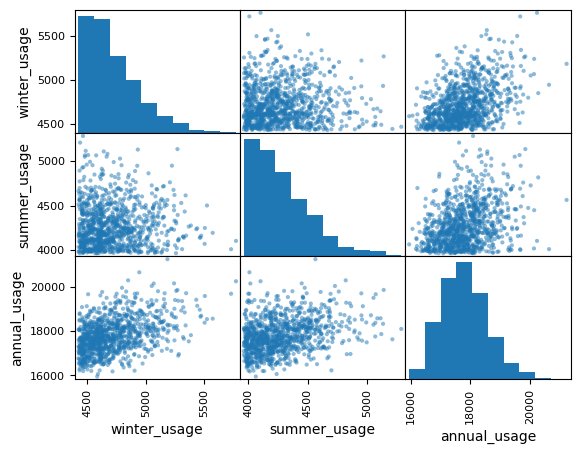

In [64]:
pd.plotting.scatter_matrix(df_features_treatment);

By plotting the two features below we can see that the treatment group and comparison pool are differently distributed, such that a random sample from the pool would not be a good counterfactual for the treatment group -- this is why we need stratified sampling.

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


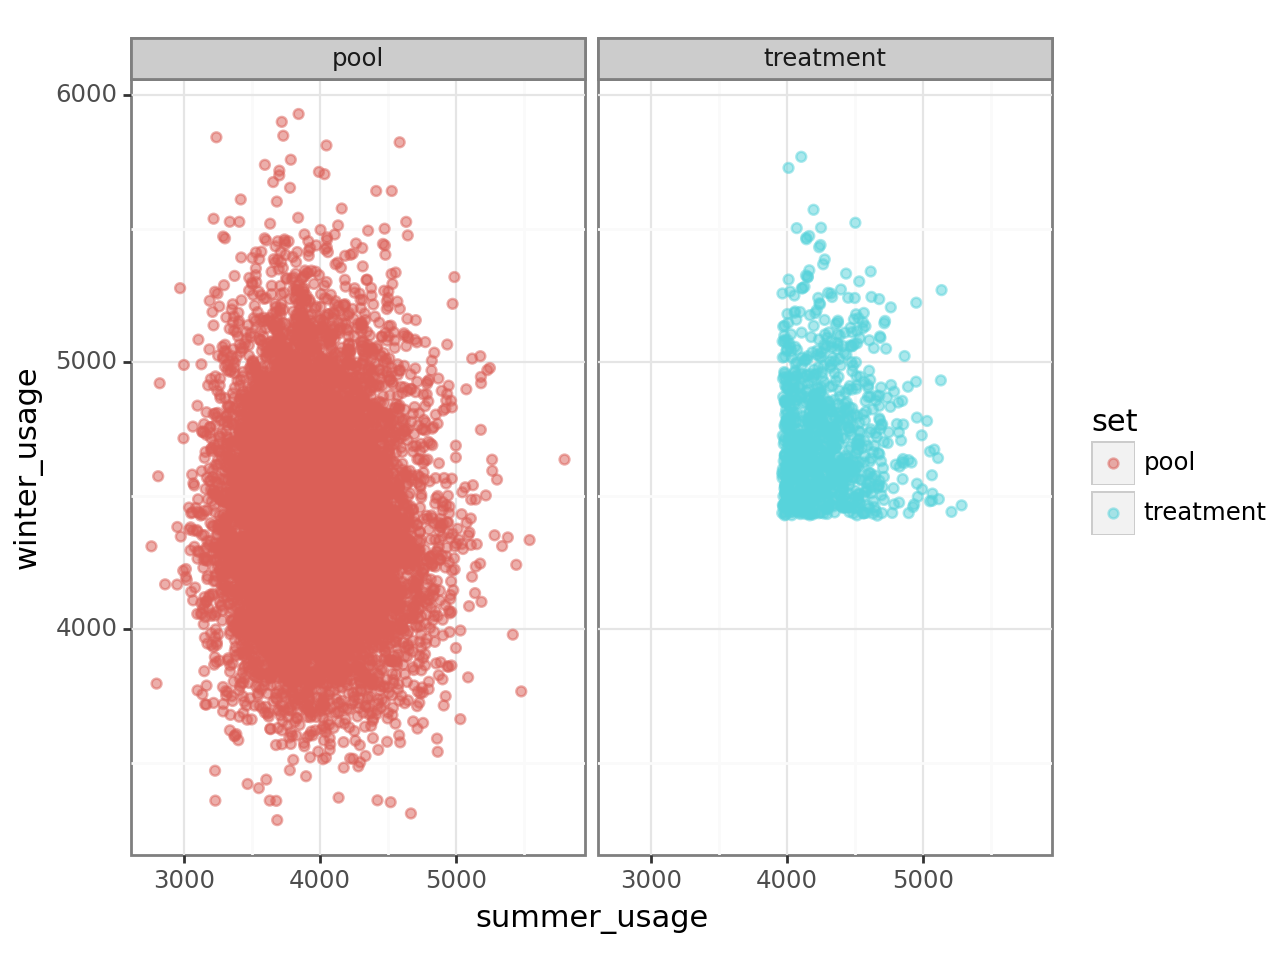

<Figure Size: (640 x 480)>

In [65]:
pn.ggplot(df_features, pn.aes(x='summer_usage', y='winter_usage', color='set')) + pn.geom_point(alpha=0.5) + pn.facet_wrap("~set") + pn.theme_bw()

To use stratified sampling, you must supply input data, a list of input columns to stratify on, and some configuration, according to the example below.   Additionally, you have the option of using the library to select an optimal configuration for you.  We'll first demonstrate the basic usage of the model, in which you supply all of the configuration information.

### Number of outputs 

The size of the comparison group is constrained by the size of the pool and by the degree to which the treatment group overlaps the pool in terms of the stratification columns.  For example, if the treatment group and pool are disjoint, no comparison group can be constructed; if only 5% of the pool overlaps the treatment group, then the effective available pool is constructed from that 5% of overlapping meters.  Generally, if you do not specify the output size, `gridmeter` will construct the largest possible comparison group up to 5000 meters.   

In [66]:
strat_col_settings = [
    {
        "column_name": "summer_usage", 
        "n_bins": 8, 
        "min_value_allowed": 3000, 
        "max_value_allowed": 6000, 
        "fixed_width": False
    },
    {
        "column_name": "winter_usage",
        "n_bins": 8, 
        "min_value_allowed": 3000, 
        "max_value_allowed": 6000, 
        "fixed_width": False
    },
]

ss_settings = gm.stratified_sampling_settings(stratification_column=strat_col_settings, random_seed=1)
ss = gm.Stratified_Sampling(ss_settings)

df_clusters, df_treatment_weights = ss.get_comparison_group(treatment_data, pool_data)

In [67]:
# Original Stratified Sampling dataframe
ss.df_raw

meter_id  winter_usage  summer_usage  annual_usage   set  \
4508   meter_4968   4505.427720   3970.405060  17545.098167  pool   
9438  meter_10387   4503.867171   4013.858016  17329.307643  pool   
4289   meter_4725   4483.273928   4009.656313  16526.007638  pool   
8556   meter_9421   4509.682932   3976.689277  16606.252819  pool   
291     meter_317   4535.403560   3981.122801  16987.930774  pool   
...           ...           ...           ...           ...   ...   
3873   meter_4266   4809.798986   4094.161810  18642.362062  pool   
8238   meter_9056   4545.862174   4079.096578  16250.529522  pool   
8714   meter_9590   4538.248390   4058.517972  17278.259246  pool   
805     meter_884   4491.103039   4073.181808  18242.786596  pool   
2617   meter_2880   4498.034953   4087.175231  17785.110096  pool   

                                             _bin  \
4508  MultBin: summer_usage_000__winter_usage_001   
9438  MultBin: summer_usage_000__winter_usage_001   
4289  MultBin: summer_usage_000__winter_usage_001   
8556  MultBin: summer_usage_000__winter_usage_001   
291   MultBin: summer_usage_000__winter_usage_001   
...                                           ...   
3873  MultBin: summer_usage_002__winter_usage_005   
8238  MultBin: summer_usage_001__winter_usage_001   
8714  MultBin: summer_usage_001__winter_usage_001   
805   MultBin: summer_usage_001__winter_usage_001   
2617  MultBin: summer_usage_001__winter_usage_001   

                              _bin_label  _outlier_bin  
4508  summer_usage_000__winter_usage_001         False  
9438  summer_usage_000__winter_usage_001         False  
4289  summer_usage_000__winter_usage_001         False  
8556  summer_usage_000__winter_usage_001         False  
291   summer_usage_000__winter_usage_001         False  
...                                  ...           ...  
3873  summer_usage_002__winter_usage_005         False  
8238  summer_usage_001__winter_usage_001         False  
8714  summer_usage_001__winter_usage_001         False  
805   summer_usage_001__winter_usage_001         False  
2617  summer_usage_001__winter_usage_001         False  

[671 rows x 8 columns]

In [68]:
# bin count
ss.diagnostics().count_bins()

bin  n_treatment  n_pct_treatment  \
0   MultBin: summer_usage_000__winter_usage_001           25            0.025   
1   MultBin: summer_usage_001__winter_usage_000           23            0.023   
2   MultBin: summer_usage_006__winter_usage_007           22            0.022   
3   MultBin: summer_usage_003__winter_usage_003           21            0.021   
4   MultBin: summer_usage_002__winter_usage_004           21            0.021   
..                                          ...          ...              ...   
59  MultBin: summer_usage_003__winter_usage_007           11            0.011   
60  MultBin: summer_usage_000__winter_usage_004           10            0.010   
61  MultBin: summer_usage_005__winter_usage_000            9            0.009   
62  MultBin: summer_usage_002__winter_usage_005            9            0.009   
63  MultBin: summer_usage_001__winter_usage_001            7            0.007   

    n_pool  n_pct_pool  n_sampled  n_pct_sampled  
0       28    0.016232         17       0.025335  
1       33    0.019130         16       0.023845  
2       30    0.017391         15       0.022355  
3       15    0.008696         14       0.020864  
4       28    0.016232         14       0.020864  
..     ...         ...        ...            ...  
59      25    0.014493          7       0.010432  
60      27    0.015652          7       0.010432  
61      28    0.016232          6       0.008942  
62      32    0.018551          6       0.008942  
63      39    0.022609          4       0.005961  

[64 rows x 7 columns]

## Viewing diagnostic plots 

Once the model has been fit, you can view several plots which will show the treatment group, comparison pool, and the final sample (i.e. the comparison group).  If the model has worked correctly, then the sample should be distributed similarly to the treatment group.  There are three plots available:

1. Histograms, showing the distribution of each stratification parameter in one dimension;
2. Scatter plots, showing an XY-plot of data points for each pair of dimensions;
3. Quantile plots with equivalence, showing the quantile distribution of each dimension, along with t-test and ks-test p-values comparison the treatment and comparison groups.  

The t- and ks-tests can be used as a measure of equivalence, however we recommend using equivalence-based optimization discussed below for better results in practice.  

In [69]:
d = ss.diagnostics()

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


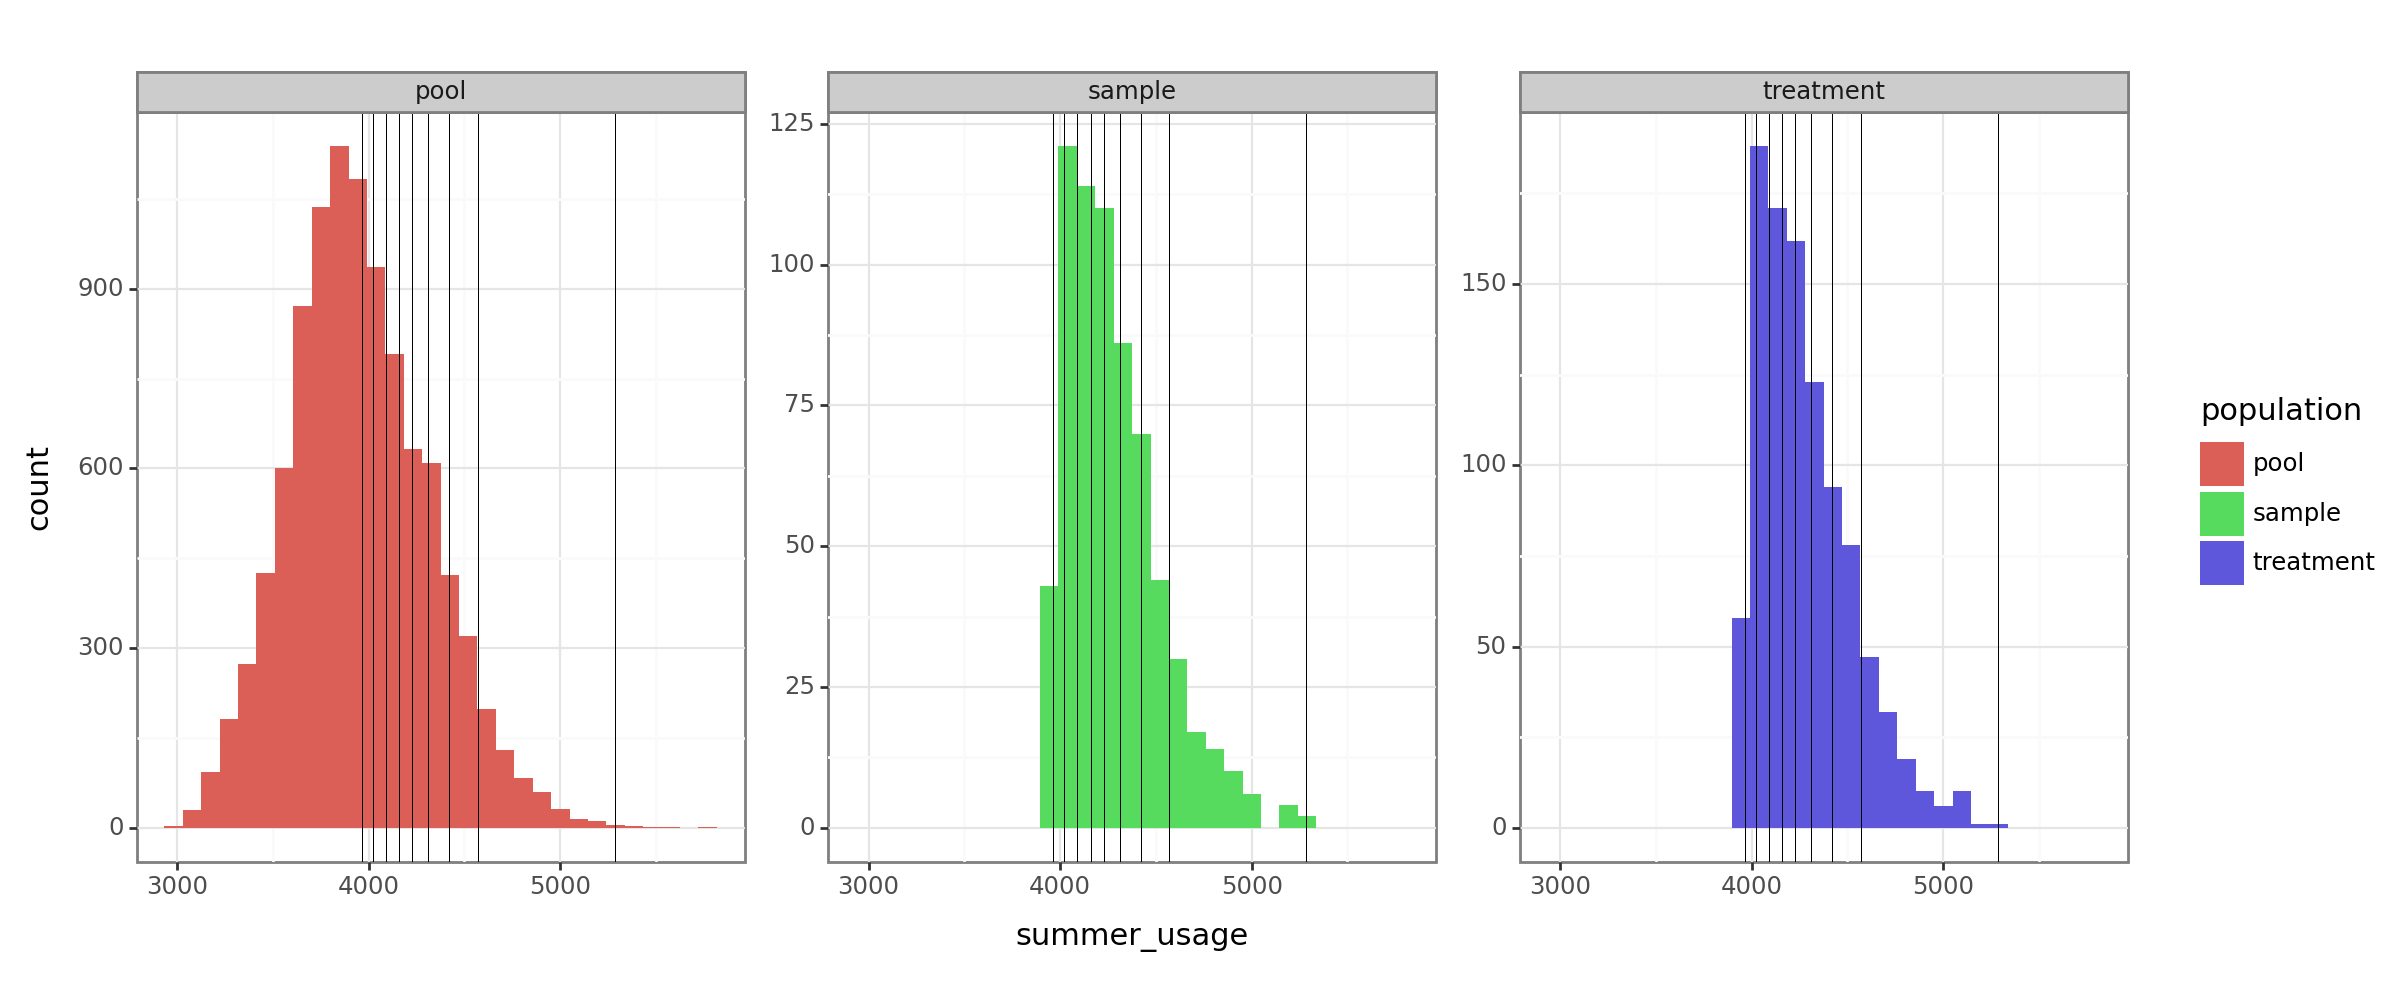

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


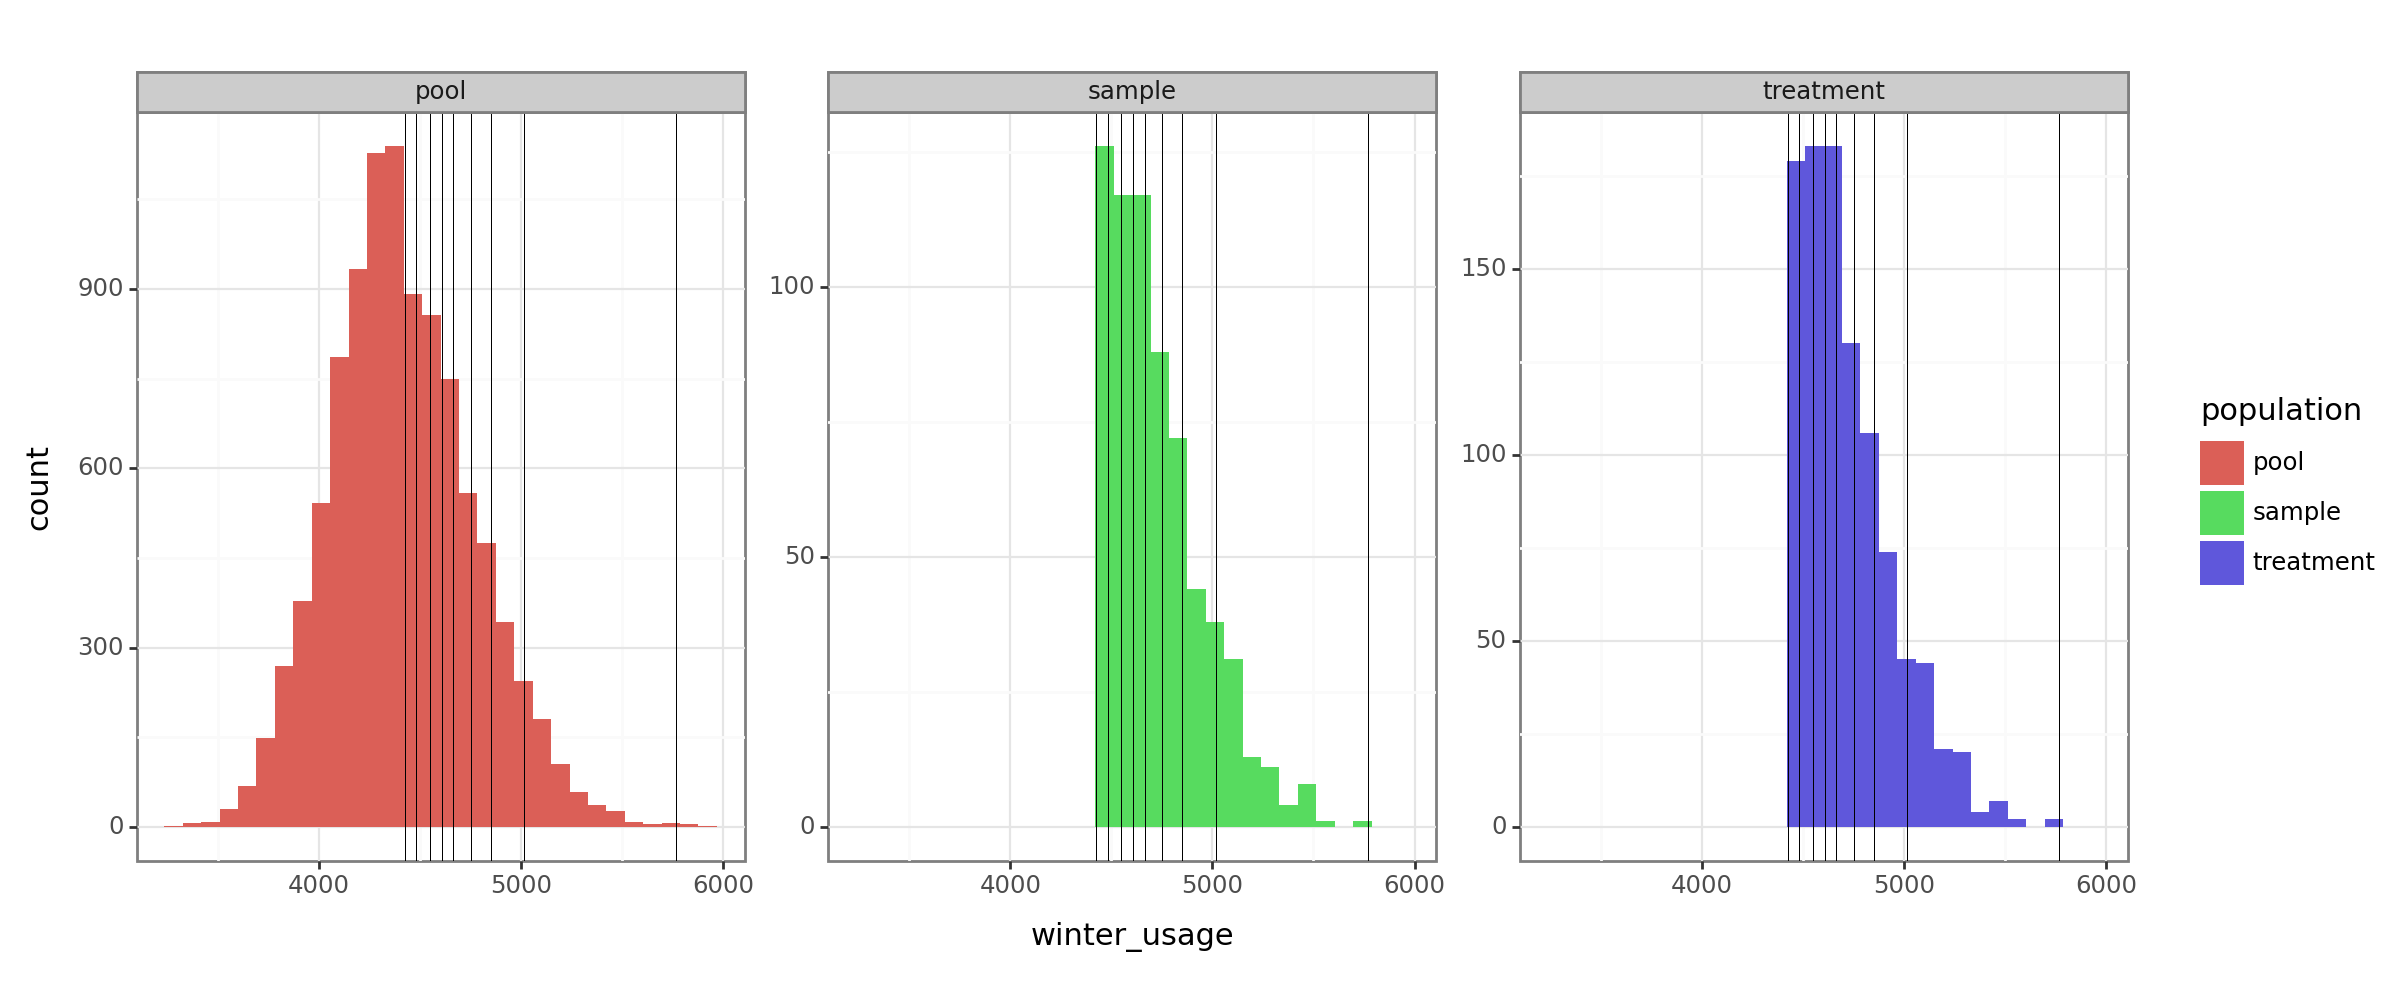

[<Figure Size: (1200 x 500)>, <Figure Size: (1200 x 500)>]

In [70]:
d.histogram()

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


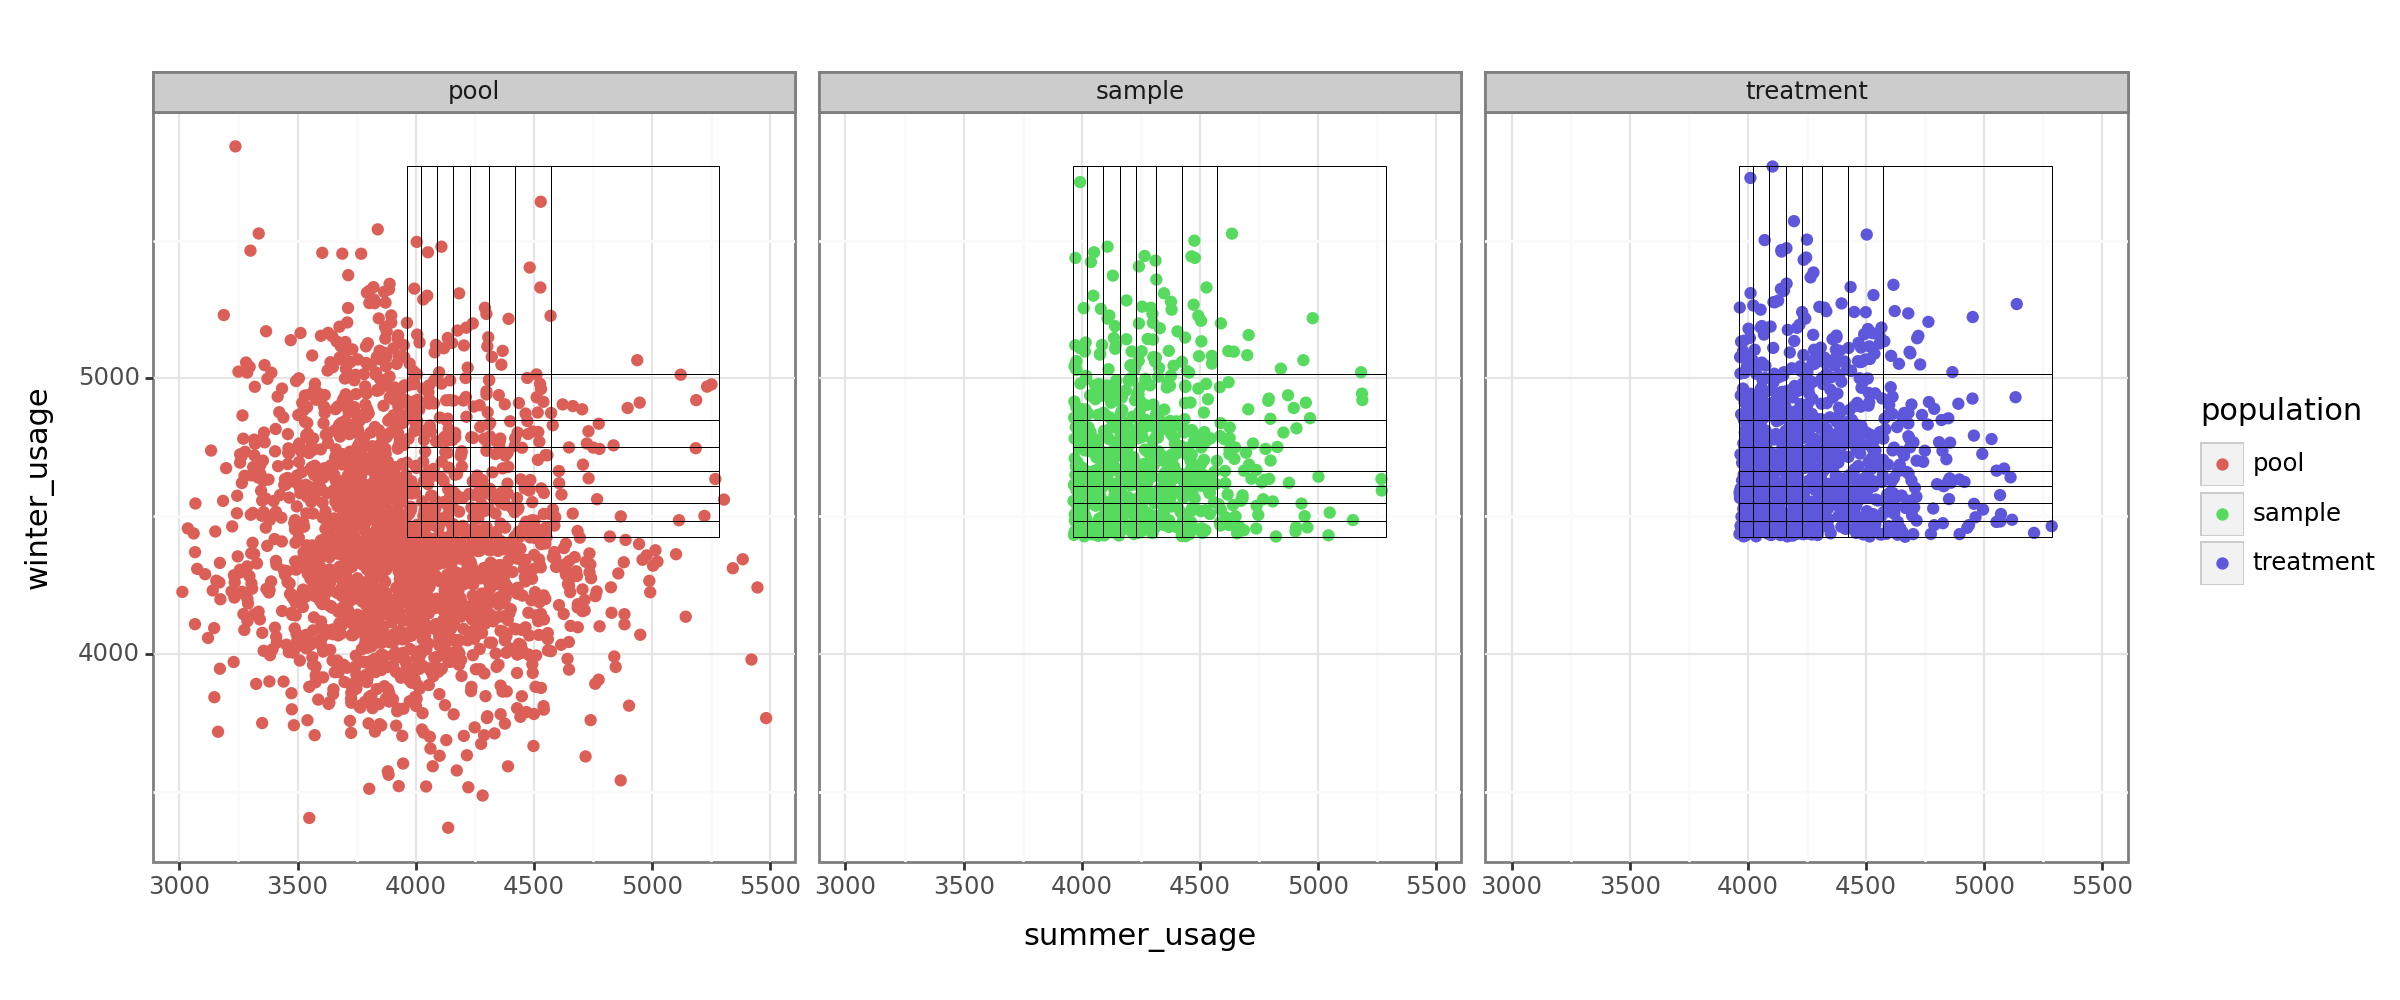

[<Figure Size: (1200 x 500)>]

In [71]:
d.scatter()

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


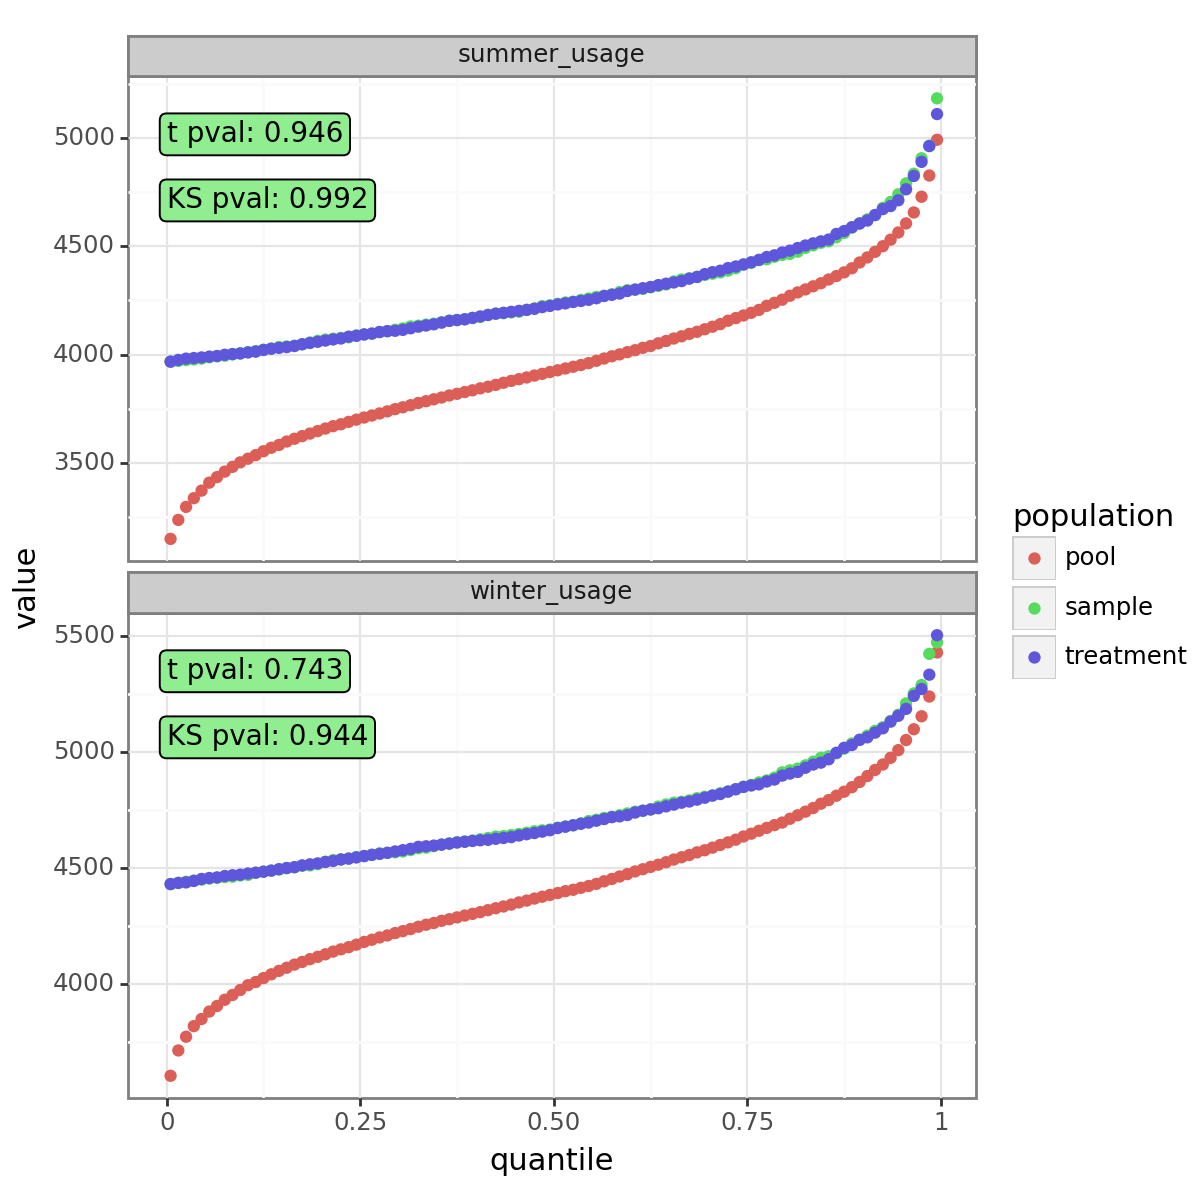

<Figure Size: (600 x 600)>

In [72]:
d.quantile_equivalence()

## Equivalence-based optimization

The above method of stratified sampling is designed to match the distributions of one or more stratification parameters.  However, often in practice the desired outcome is to have a comparison group with similar usage patterns to a treatment group as measured through a load shape or similar set of time-series features.  To ensure that the load shapes are equivalent, you can use the `StratifiedSamplingBinSelector` which selects an optimal binning arrangement which minimizes load shape error between the treatment and comparison groups. 

In the following example, a bin selector is used to match on monthly load shapes.  

In [73]:
strat_col_settings = {
    "equivalence_method": "chisquare",
    "min_n_bins": 2,
    "max_n_bins": 8,
    "stratification_column": [{
            "column_name": "summer_usage", 
            "n_bins": None, 
            "min_value_allowed": 3000, 
            "max_value_allowed": 6000, 
            "fixed_width": False
        },
        {
            "column_name": "winter_usage",
            "n_bins": None, 
            "min_value_allowed": 3000, 
            "max_value_allowed": 6000, 
            "fixed_width": False
    }],
    "random_seed": 1,
}

dss_settings = gm.distance_stratified_sampling_settings(**strat_col_settings)
dss = gm.Stratified_Sampling(dss_settings)

df_clusters2, df_treatment_weights2 = dss.get_comparison_group(treatment_data, pool_data)

INFO:root:Computing bins: summer_usage:2 bins,winter_usage:2 bins distance: 13.23, 
INFO:root:Computing bins: summer_usage:3 bins,winter_usage:2 bins distance: 13.35, 


INFO:root:Computing bins: summer_usage:4 bins,winter_usage:2 bins distance: 12.78, 
INFO:root:Computing bins: summer_usage:5 bins,winter_usage:2 bins distance: 15.72, 
INFO:root:Computing bins: summer_usage:6 bins,winter_usage:2 bins distance: 15.16, 
INFO:root:Computing bins: summer_usage:7 bins,winter_usage:2 bins distance: 11.73, 
INFO:root:Computing bins: summer_usage:8 bins,winter_usage:2 bins distance: 13.77, 
INFO:root:Computing bins: summer_usage:2 bins,winter_usage:3 bins distance: 11.31, 
INFO:root:Computing bins: summer_usage:3 bins,winter_usage:3 bins distance: 14.54, 
INFO:root:Computing bins: summer_usage:4 bins,winter_usage:3 bins distance: 15.27, 
INFO:root:Computing bins: summer_usage:5 bins,winter_usage:3 bins distance: 13.04, 
INFO:root:Computing bins: summer_usage:6 bins,winter_usage:3 bins distance: 11.62, 
INFO:root:Computing bins: summer_usage:7 bins,winter_usage:3 bins distance: 14.73, 
INFO:root:Computing bins: summer_usage:8 bins,winter_usage:3 bins distance: 

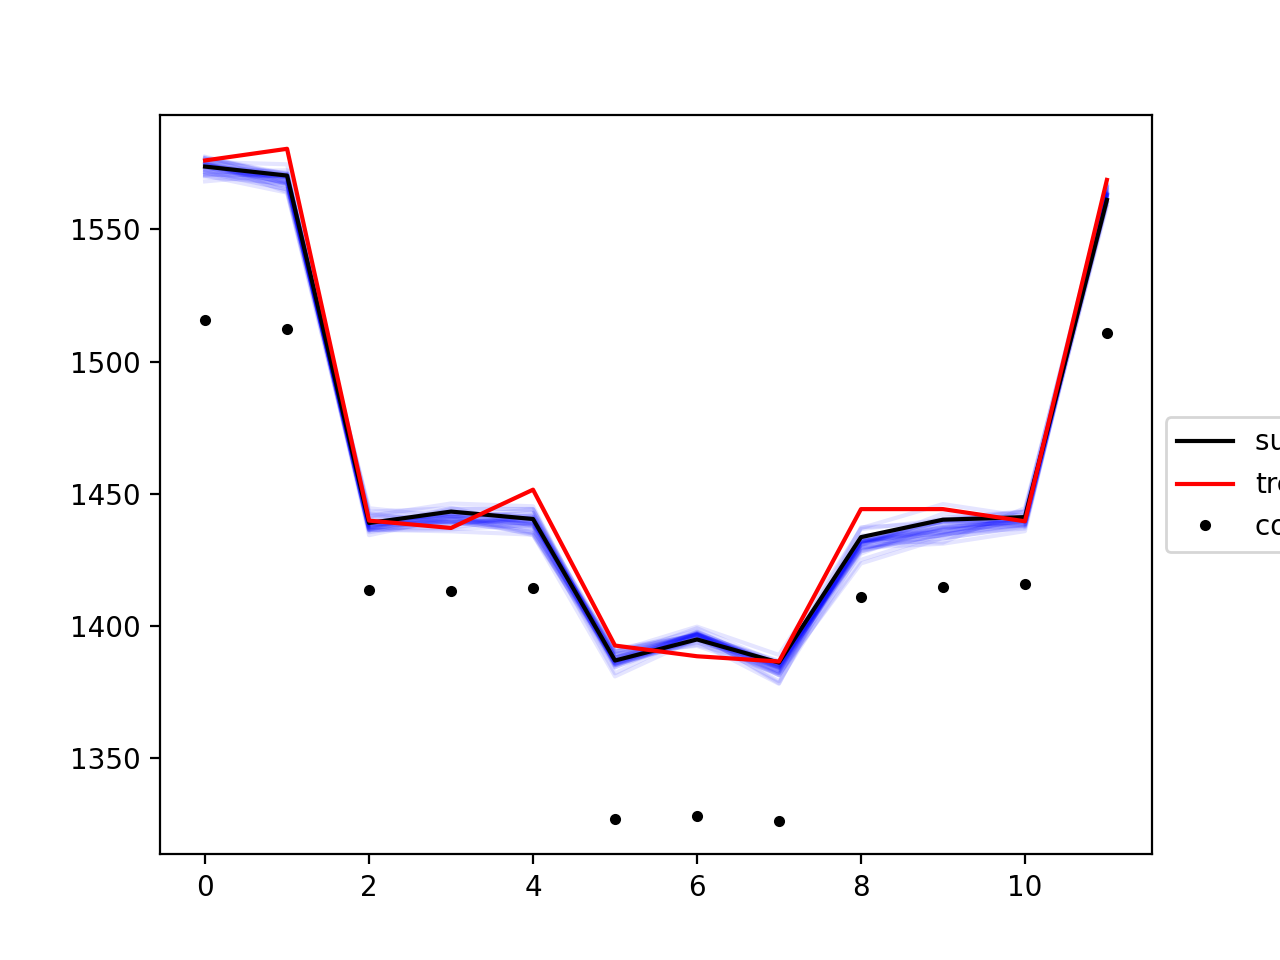

In [74]:
dss.model_bin_selector.plot_records_based_equiv_average()

The graph above shows the monthly load shape of the treatment group (red), the selected comparison group (black), other candidate comparison groups (blue), and the comparison pool (dots).  In this case, all of the candidates were a good match, so the selection process was probably unnecessary, however in more complex cases this method can be useful.  The final binning arrangement is available in the model object as follows:

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


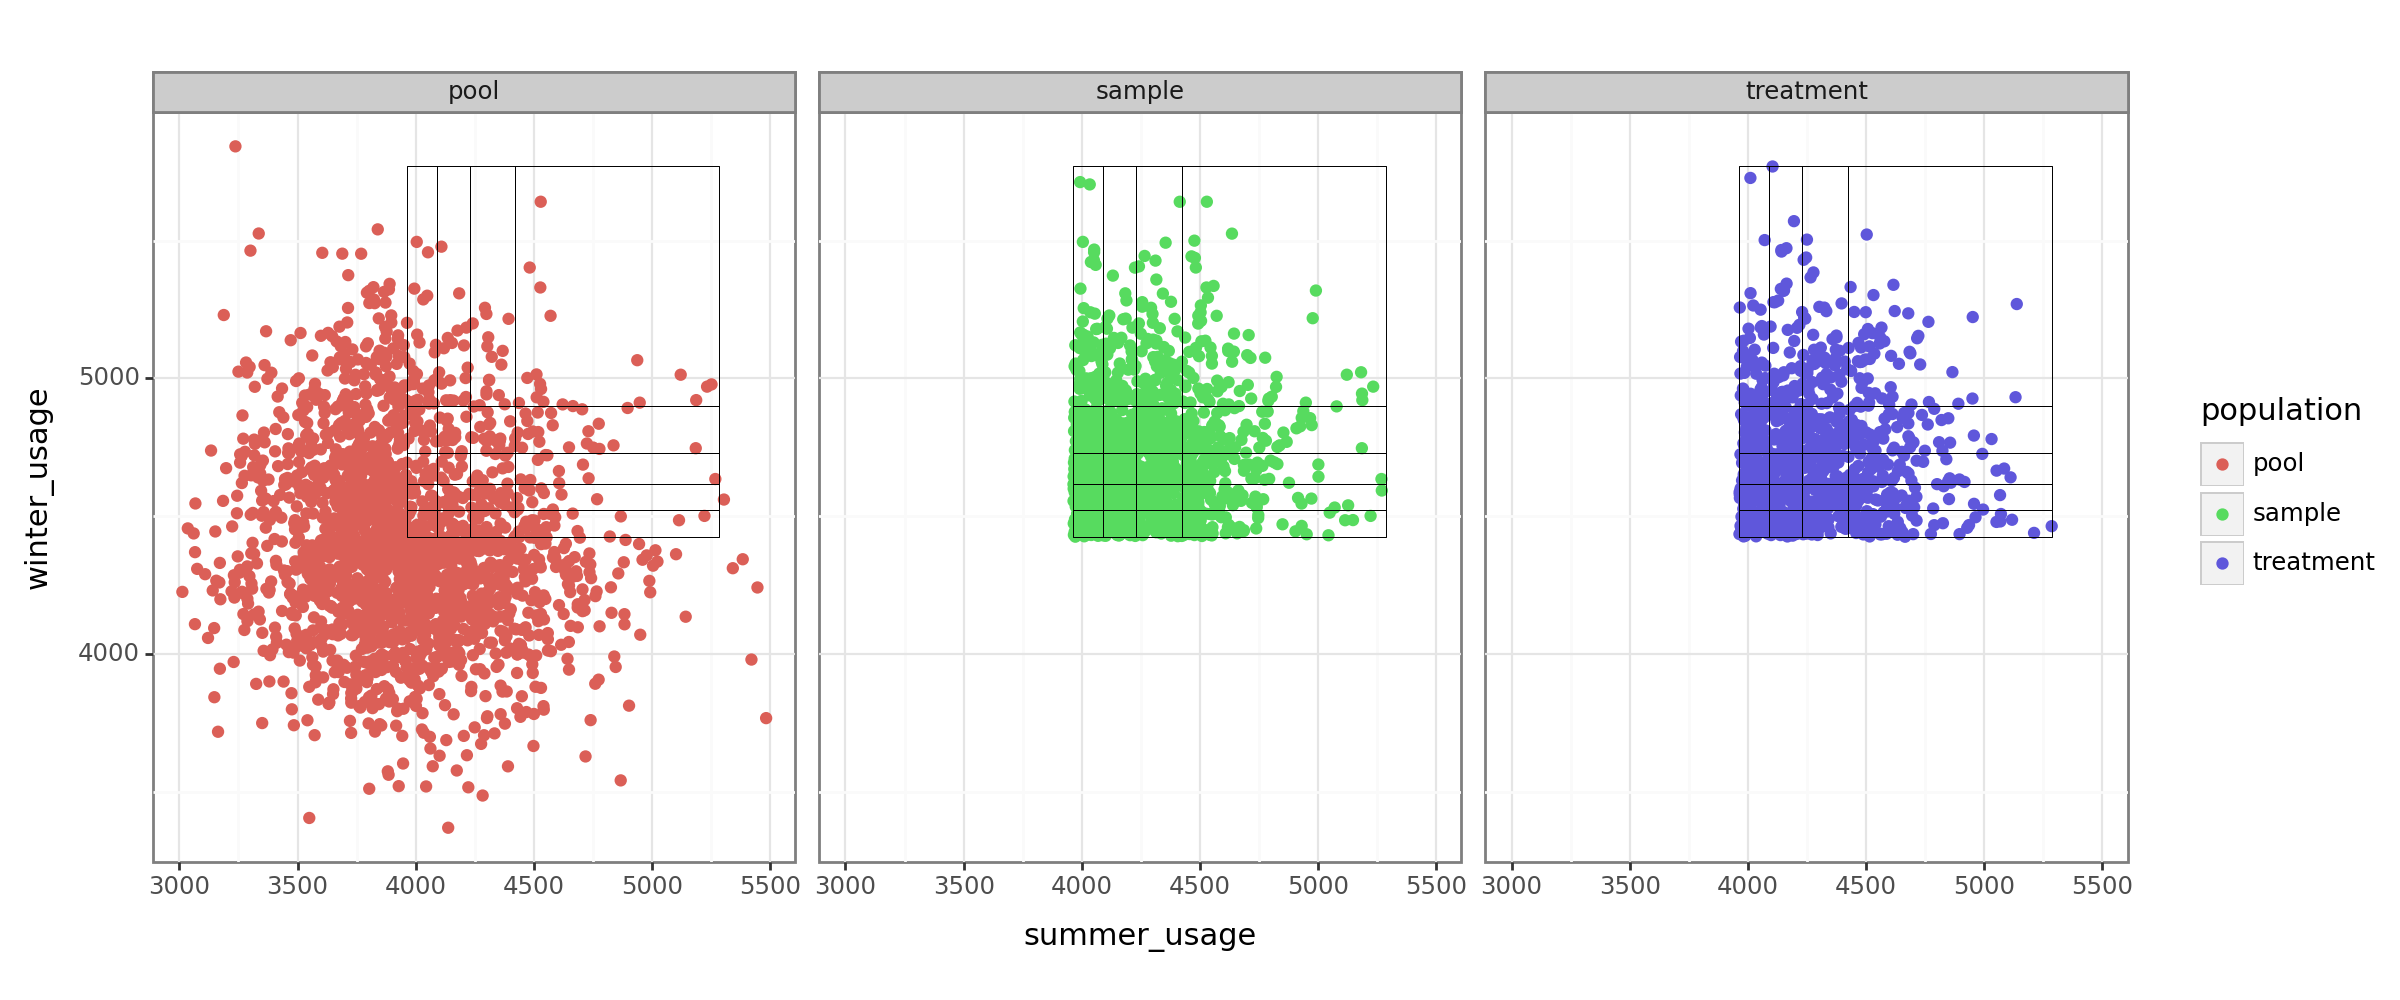

[<Figure Size: (1200 x 500)>]

In [75]:
dss.diagnostics().scatter()

In [76]:
dss.df_raw

meter_id  winter_usage  summer_usage  annual_usage   set  \
4022  meter_4429   4741.643851   4267.636270  18118.461882  pool   
158    meter_173   4761.392136   4394.450862  18463.295965  pool   
3088  meter_3406   4815.746460   4235.112002  17891.600654  pool   
4209  meter_4635   4757.550221   4353.782035  18298.465782  pool   
2615  meter_2878   4750.051247   4307.325049  17954.936774  pool   
...          ...           ...           ...           ...   ...   
2300  meter_2529   4515.644385   4291.857032  16285.051441  pool   
4748  meter_5222   4509.345040   4237.311443  18014.343337  pool   
1335  meter_1461   4477.149185   4292.699150  17258.505291  pool   
8218  meter_9035   4431.342182   4257.969041  18174.937666  pool   
622    meter_683   4457.027981   4307.996252  17155.849849  pool   

                                             _bin  \
4022  MultBin: summer_usage_002__winter_usage_003   
158   MultBin: summer_usage_002__winter_usage_003   
3088  MultBin: summer_usage_002__winter_usage_003   
4209  MultBin: summer_usage_002__winter_usage_003   
2615  MultBin: summer_usage_002__winter_usage_003   
...                                           ...   
2300  MultBin: summer_usage_002__winter_usage_000   
4748  MultBin: summer_usage_002__winter_usage_000   
1335  MultBin: summer_usage_002__winter_usage_000   
8218  MultBin: summer_usage_002__winter_usage_000   
622   MultBin: summer_usage_002__winter_usage_000   

                              _bin_label  _outlier_bin  
4022  summer_usage_002__winter_usage_003         False  
158   summer_usage_002__winter_usage_003         False  
3088  summer_usage_002__winter_usage_003         False  
4209  summer_usage_002__winter_usage_003         False  
2615  summer_usage_002__winter_usage_003         False  
...                                  ...           ...  
2300  summer_usage_002__winter_usage_000         False  
4748  summer_usage_002__winter_usage_000         False  
1335  summer_usage_002__winter_usage_000         False  
8218  summer_usage_002__winter_usage_000         False  
622   summer_usage_002__winter_usage_000         False  

[1305 rows x 8 columns]

This concludes the tutorial.  For questions, comments, or issues, please raise a Github issue here:  
https://github.com/recurve-methods/comparison_groups/issues

We thank you for your interest and participation in this project and look forward to your feedback.